In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy 

In [52]:
def read_excel(filename, usecols, header, nrows = None, sheet_name = 0):
    '''
    Creates pandas.DataFrame from excel file with pandas.MultiIndex.

    :param filename:   name of excel file
    :param usecols:    int list with indices of columns to read
    :param header:     int list with indices of header rows
    :param sheet_name: index or name of sheet to read
    '''
    if header == None or header == 0:
        return pd.read_excel(filename, header = header, usecols = usecols, nrows = nrows, sheet_name = sheet_name)

    # Read header rows
    __header_df = pd.read_excel(filename, nrows = 0, header = header, sheet_name = sheet_name)
    __header_mi = pd.MultiIndex.from_tuples(__header_df.columns.to_list())

    # Read data and set multiindex
    __data = pd.read_excel(filename, skiprows = header, header = None, usecols = usecols, nrows = nrows, sheet_name = sheet_name)
    __data.columns = __header_mi[usecols]

    return __data

def map_excel(data, fmt):
    '''
    Renames columns in pandas.DataFrame.

    :param __data: pandas.DataFrame to rename columns in
    :param __fmt:  map old_names->new_names

    Example:
        fmt = {
            'B, Wb' : 'B',
            'Webermeter' : 'Wm',
            'L, m' : 'L'
        }

        data = map_excel(data, fmt)
    '''

    return data.rename(columns = fmt)

In [53]:
def interp_linear(x, y):
    coeffs = np.polyfit(x, y, 1)
    return lambda x: coeffs[0] * x + coeffs[1]

def plot(x, y, label = None, color = None, xerr = 0, yerr = 0,
         begin = 0, end = None, exclude = [],
         x_min = None, x_max = None, func = interp_linear):
    '''
    Creates plot with approximating line.

    :param x:       x coordinates of points
    :param y:       y coordinates of points
    :param label:   label of plot in legend
    :param color:   color of plot
    :param xerr:    x errors of points
    :param yerr:    y errors of points
    :param begin:   index of first point used for approximating line
    :param end:     index of last point used for approximating line
    :param exclude: indices of 'error' points
    :param x_min:   left end of approximating line
    :param x_max:   right end of approximating line
    :param func:    lambda function for approximating line

    :return x_clean, y_clean: pd.Series of values used for approximating line
    '''
    
    assert len(x) == len(y), "x and y must have same length"
    
    end = (len(x) - 1) if (end == None) else end
    
    x_clean = []
    y_clean = []
    for i in range(begin, end + 1):
        if i in exclude:
            continue
        x_clean.append(x[i])
        y_clean.append(y[i])
    
    x_min = min(x_clean) if (x_min == None) else x_min
    x_max = max(x_clean) if (x_max == None) else x_max

    equ = func(x_clean, y_clean)
    x_space = np.linspace(x_min, x_max, 100)
    
    p = plt.plot(x_space, equ(x_space), label = label, c = color)
    plt.errorbar(x, y, xerr = xerr, yerr = yerr, fmt = '.', c = p[-1].get_color())
    
    for i in exclude:
        plt.scatter(x[i], y[i], s = 60, marker = 'x', c = 'red')

    return pd.Series(x_clean), pd.Series(y_clean), equ

In [54]:
def rename(columns, fmt, inplace = False):
    __init_columns = columns
    __columns = __init_columns 
    
    for key in fmt.keys():
        __renamed = []
        
        for i in range(len(__init_columns)):
            col = __columns[i]

            if type(key) is tuple:
                if type(col) is tuple and __init_columns[i][:len(key)] == key:
                    col = __columns[i][:len(key) - 1] + (fmt[key],) + __columns[i][len(key):]
            elif type(key) is str:
                if type(col) is str and col == key:
                    col = fmt[key]
                elif type(col) is tuple and col[0] == key:
                    col = (fmt[key],) + __columns[i][1:]
            else:
                assert 0, 'Format index must be str or tuple'
                
            __renamed.append(col) 
        
        __columns = __renamed
                    
    return __columns #pd.Index(__columns, tupleize_cols = True)

class table:
    data = pd.DataFrame()
    latex_fmt = {
        # key    name      precision
        # 'I' : ['$I$, A', '{:.1f}'],
        # ('Group', 'I') : ['$I$, A', '{:.1f}'],
    }

    DEFAULT_PRECISION = '{:.1f}'
    DEFAULT_NAME = '!unnamed!'

    def __init__(self, data, fmt = {}):
        self.data = data
        self.latex_fmt = fmt
        
    def get_names(self):
        __fmt = self.latex_fmt
        return {__i:__fmt[__i][0] for __i in __fmt.keys() if len(__fmt[__i]) > 0}

    def get_precisions(self):
        __fmt = self.latex_fmt
        return {__i:__fmt[__i][1] for __i in __fmt.keys() if len(__fmt[__i]) > 1}

    def get_scales(self):
        __fmt = self.latex_fmt
        return {__i:__fmt[__i][2] for __i in __fmt.keys() if len(__fmt[__i]) > 2}

    def get_fmt(self):
        return self.latex_fmt
    
    def get_data(self):
        return self.data
    
    def set_name(self, key, name):
        if key in self.latex_fmt:
            __tmp = self.latex_fmt[key]
            __tmp[0] = name
        else:
            __tmp = [name, DEFAULT_PRECISION]

        self.latex_fmt[key] = __tmp

    def set_precision(self, key, precision):
        if key in self.latex_fmt:
            __tmp = self.latex_fmt[key]
            __tmp[1] = precision
        else:
            __tmp = [DEFAULT_NAME, precision]
        
        self.latex_fmt[key] = __tmp

    def set_fmt(self, fmt):
        self.latex_fmt = fmt
    
    def scale(self):
        __tab = table(self.data.copy(), self.latex_fmt.copy())
        
        __scales = self.get_scales()
        for key in list(__scales.keys()):
            if key in list(__tab.data.columns.values):
                __tab.data[key] *= 10**(__scales[key])

        return __tab
    
    def rename(self):
        __tab = table(self.data.copy(), self.latex_fmt.copy())
        
        __tab.data.columns = pd.Index(rename(__tab.data.columns.values, __tab.get_names()), tupleize_cols = True)
        __tab.latex_fmt = dict(zip(rename(list(__tab.latex_fmt.keys()), __tab.get_names()), list(__tab.latex_fmt.values())))
            
        return __tab  
        
    def insert(self, loc, column, value, fmt = []):
        assert not (column in self.data), "Column " + str(column) + " already exists"
        self.data.insert(loc = loc, column = column, value = value, allow_duplicates = False)
        
        if fmt:
            self.latex_fmt[column] = fmt
        
    def delete(self, column):
        assert (column in self.data), "Column " + str(column) + " does not exist"
        del self.data[column]
            
    def to_latex(self, file = None):
        '''
        Applies LaTeX formatting and saves table to file.
        
        :param filename: output file
        
        Example:
        
        fmt = {
            'x': ['$x$, дел.',   '{:.1f}'],
            'x0': ['$x_0$, дел.', '{:.3f}'],
            
            # It supports multi index renaming
            ('RC', 'R'): ['$R$, дел.',   '{:.2f}'], 
        }
        
        my_table.to_latex('my_table.tex')
        '''
        
        # Rename also changes latex_fmt. 
        # That is why we need to assign rename() to local variable
        __tab = self.rename() 
        return __tab.scale().data.style.format(__tab.get_precisions()) \
                    .hide(level=0, axis=0)                                 \
                    .to_latex( 
                        buf = file,
                        column_format="c" * len(__tab.data.columns.values),
                        hrules=True,
                        multicol_align = 'c',
                        environment = ''
                    )
    
    
def mnk(x, y, fmt = None, file = None, precision = 2):

    if fmt == None:
        fmt = {
                '<x>':    ['$\overline{x}$', '{:.' + str(precision) + 'e}'],
                'sx':     ['$\sigma_x^2$',   '{:.' + str(precision) + 'e}'],
                '<y>':    ['$\overline{y}$', '{:.' + str(precision) + 'f}'],
                'sy':     ['$\sigma_y^2$',   '{:.' + str(precision) + 'e}'],
                'rxy':    ['$r_{xy}$',       '{:.' + str(precision) + 'e}'],
                'a':      ['$a$',            '{:.' + str(precision) + 'f}'],
                'da':     ['$\Delta a$',     '{:.' + str(precision) + 'f}'],
                'b':      ['$b$',            '{:.' + str(precision) + 'f}'],
                'db':     ['$\Delta b$',     '{:.' + str(precision) + 'f}'],
        }
    
    __sx = (x**2).mean() - (x.mean())**2
    __sy = (y**2).mean() - (y.mean())**2
    
    __rxy = (y*x).mean() - (y.mean() * x.mean())
    
    __a  = __rxy / __sx
    __da = (1/(len(x) - 2) * (__sy/__sx - __a**2))**(0.5)
    
    __b  = y.mean() - __a * x.mean()
    __db = __da*(__sx + (x.mean())**2)**(1/2)

    __data = pd.DataFrame({
        '<x>':   [x.mean()],
        'sx':    [__sx],
        '<y>':   [y.mean()],
        'sy':    [__sy],
        'rxy':   [__rxy],
        'a':     [__a],
        'da':    [__da],
        'b':     [__b],
        'db':    [__db],
    })
    
    __tab = table(__data, fmt)
    if file:
        __tab.to_latex(file)
    
    return __tab

In [55]:
class setup:
    dummy = 0
    
    em_SN = 75 * 10**-4    # m^2 -- effective area of probe coil
    wb_err = 0.015 * 10    # mWb -- error of webermeter
    tl_eps = 0.06          #     -- relative error of teslameter
    em_supply = 0.005      # A   -- error of electromagnet power supply
    
    B_eps = 0.05           #     -- relative error of magnetic field
    A2_err = 0.005         # mA  -- relative error of main current in plate
    V1_err = 3.5           # mkV -- error of Hall's EMF
    plate_h = 1.0          # mm  -- plate thickness
    plate_l = 5.0          # mm  -- plate length
    plate_a = 4.0          # mm  -- plate width
    plate_err = 0.05       # mm  -- error of plate size


## Electromagnet calibration

In [56]:
xls = {
    'I, A' : 'I',
    'Phi, mWb' : 'Phi',
    'B, mT' : 'B'
}

em_data = read_excel("data/334.ods", usecols=range(0, 4), header=[0, 1], nrows = 10)
em_data = map_excel(em_data, xls)
em_data

Webermeter      Teslameter      
           I  Phi          I     B
0       0.15  0.9       0.15   154
1       0.30  1.7       0.30   280
2       0.45  2.4       0.45   403
3       0.60  3.2       0.60   533
4       0.75  4.0       0.75   653
5       0.90  4.8       0.90   809
6       1.05  5.4       1.05   964
7       1.20  5.9       1.20  1083
8       1.35  6.2       1.35  1145
9       1.50  6.5       1.50  1180

In [57]:
wb_B = em_data[('Webermeter', 'Phi')] / setup.em_SN
print(wb_B)

em_fmt = {
    'Webermeter' : ['Веберметр'],
    'Teslameter' : ['Тесламетр'],
    ('Webermeter', 'I') : ['$I_M$, А', '{:.2f}', 0],
    ('Webermeter', 'Phi') : ['$\Phi$, мВб', '{:.1f}', 0],
    ('Webermeter', 'B') : ['$B$, мТл', '{:.0f}', 0],
    ('Teslameter', 'I') : ['$I_M$, А', '{:.2f}', 0],
    ('Teslameter', 'B') : ['$B$, мТл', '{:.0f}', 0],
}

em_tbl = table(em_data, em_fmt)
em_tbl.insert(2, ('Webermeter', 'B'), wb_B)
em_tbl.rename().to_latex('gen/electromagnet.tex')

0    120.000000
1    226.666667
2    320.000000
3    426.666667
4    533.333333
5    640.000000
6    720.000000
7    786.666667
8    826.666667
9    866.666667
Name: (Webermeter, Phi), dtype: float64


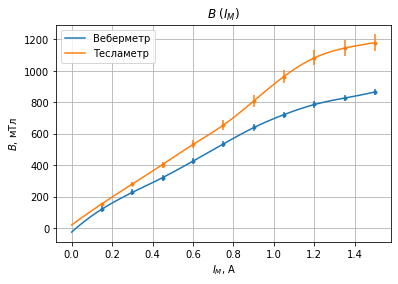

In [58]:
def interp_spl(x, y):
    return UnivariateSpline(x, y)

d = em_tbl.get_data()
x, y, wb_equ = plot(d[('Webermeter', 'I')], d[('Webermeter', 'B')], label = 'Веберметр',
                    xerr = setup.em_supply, yerr = setup.wb_err / setup.em_SN, x_min = 0, func = interp_spl)
x, y, tl_equ = plot(d[('Teslameter', 'I')], d[('Teslameter', 'B')], label = 'Тесламетр',
                    xerr = setup.em_supply, yerr = setup.tl_eps * d[('Webermeter', 'B')], x_min = 0, func = interp_spl)

plt.title("$B \; (I_M)$")
plt.xlabel("$I_M$, А")
plt.ylabel("$B$, мТл")
plt.grid(True)
plt.legend()

plt.savefig("gen/electromagnet_BI.pdf")


In [59]:
mnk(d[('Webermeter', 'I')], d[('Webermeter', 'B')], file = 'gen/webermeter_mnk.tex')
mnk(d[('Teslameter', 'I')], d[('Teslameter', 'B')], file = 'gen/teslameter_mnk.tex').get_data()

,<x>,sx,<y>,sy,rxy,a,da,b,db
0,0.825,0.185625,720.4,124535.24,151.035,813.656566,33.278952,49.133333,30.97357


## Hall's EMF

In [60]:
xls = {
    'I, mA' : 'I',
    'I, A' : 'I',
    'U_34, mkV' : 'U'
}

cols = range(15, 29)
print('Cols:', cols)

he_data = read_excel("data/334.ods", usecols = cols, header = [0, 1, 2])
he_data = map_excel(he_data, xls)

xls = {
    'I, mA' : 'I',
    'U_0, mkV' : 'U'
}

u0_data = read_excel("data/334.ods", usecols = [10, 11], header = [0, 1], nrows = 7)
u0_data = map_excel(u0_data, xls)
u0_data = u0_data['Disbalance']
print(u0_data)

u0_dict = {
    u0_data['I'][indx] : u0_data['U'][indx] for indx in range(0, len(u0_data))
}
print(u0_dict)

he_data

Cols: range(15, 29)
      I   U
0  0.14  -1
1  0.30  -2
2  0.45  -6
3  0.60  -8
4  0.75 -12
5  0.90 -15
6  1.00 -17
{0.14: -1, 0.3: -2, 0.45: -6, 0.6: -8, 0.75: -12, 0.9: -15, 1.0: -17}


I                                                                       
   0.14       0.30       0.45       0.60       0.75       0.90       1.00     
      I    U     I    U     I    U     I    U     I    U     I    U     I    U
0  0.15  -13  0.15  -31  0.15  -50  0.15  -65  0.15  -82  0.15  -99  0.15 -113
1  0.30  -27  0.30  -62  0.30  -96  0.30 -127  0.30 -159  0.30 -193  0.30 -220
2  0.45  -41  0.45  -94  0.45 -144  0.45 -193  0.45 -241  0.45 -294  0.45 -324
3  0.60  -56  0.60 -125  0.60 -191  0.60 -253  0.60 -317  0.60 -386  0.60 -428
4  0.75  -68  0.75 -153  0.75 -233  0.75 -313  0.75 -390  0.75 -474  0.75 -526
5  0.90  -82  0.90 -180  0.90 -273  0.90 -368  0.90 -460  0.90 -558  0.90 -614
6  1.05  -92  1.05 -203  1.05 -308  1.05 -414  1.05 -517  1.05 -623  1.05 -693
7  1.20  -99  1.20 -220  1.20 -334  1.20 -447  1.20 -558  1.20 -675  1.20 -749
8  1.35 -105  1.35 -233  1.35 -352  1.35 -472  1.35 -590  1.35 -713  1.35 -790
9  1.50 -110  1.50 -243  1.50 -367  1.50 -493  1.50 -618  1.50 -745  1.50 -826

In [61]:
# Get values of I in index
cols = list(dict.fromkeys(he_data.columns.get_level_values(1)))
print(cols)

# Subtract U_0 for all U
assert len(u0_dict.keys()) == len(cols), "U_0 amount and amount of I in index doesn't match"
for num in cols:
    he_data[('I', num, 'U')] -= u0_dict[num]

# Convert I in index from float to string (0.9 -> '0.90')
cols = ['{:.2f}'.format(num) for num in cols]
he_data.columns = he_data.columns.set_levels(cols, level = 1)
print(he_data.columns)

he_data

[0.14, 0.3, 0.45, 0.6, 0.75, 0.9, 1.0]
MultiIndex([('I', '0.14', 'I'),
            ('I', '0.14', 'U'),
            ('I', '0.30', 'I'),
            ('I', '0.30', 'U'),
            ('I', '0.45', 'I'),
            ('I', '0.45', 'U'),
            ('I', '0.60', 'I'),
            ('I', '0.60', 'U'),
            ('I', '0.75', 'I'),
            ('I', '0.75', 'U'),
            ('I', '0.90', 'I'),
            ('I', '0.90', 'U'),
            ('I', '1.00', 'I'),
            ('I', '1.00', 'U')],
           )


I                                                                       
   0.14       0.30       0.45       0.60       0.75       0.90       1.00     
      I    U     I    U     I    U     I    U     I    U     I    U     I    U
0  0.15  -12  0.15  -29  0.15  -44  0.15  -57  0.15  -70  0.15  -84  0.15  -96
1  0.30  -26  0.30  -60  0.30  -90  0.30 -119  0.30 -147  0.30 -178  0.30 -203
2  0.45  -40  0.45  -92  0.45 -138  0.45 -185  0.45 -229  0.45 -279  0.45 -307
3  0.60  -55  0.60 -123  0.60 -185  0.60 -245  0.60 -305  0.60 -371  0.60 -411
4  0.75  -67  0.75 -151  0.75 -227  0.75 -305  0.75 -378  0.75 -459  0.75 -509
5  0.90  -81  0.90 -178  0.90 -267  0.90 -360  0.90 -448  0.90 -543  0.90 -597
6  1.05  -91  1.05 -201  1.05 -302  1.05 -406  1.05 -505  1.05 -608  1.05 -676
7  1.20  -98  1.20 -218  1.20 -328  1.20 -439  1.20 -546  1.20 -660  1.20 -732
8  1.35 -104  1.35 -231  1.35 -346  1.35 -464  1.35 -578  1.35 -698  1.35 -773
9  1.50 -109  1.50 -241  1.50 -361  1.50 -485  1.50 -606  1.50 -730  1.50 -809

In [62]:
he_tbl_UI = table(he_data)
he_tbl_UB = copy.deepcopy(he_tbl_UI)

# Convert I to B using magnet calibration
for num in cols:
    new_B = tl_equ(he_data[('I', num, 'I')])
    new_loc = he_data.columns.get_loc(('I', num, 'I'))
    he_tbl_UB.delete(('I', num, 'I'))
    he_tbl_UB.insert(value = new_B, column = ('I', num, 'B'), loc = new_loc)

he_tbl_UB.get_data()

I                                                             \
          0.14              0.30              0.45              0.60        
             B    U            B    U            B    U            B    U   
0   154.073984  -12   154.073984  -29   154.073984  -44   154.073984  -57   
1   279.552827  -26   279.552827  -60   279.552827  -90   279.552827 -119   
2   404.206156  -40   404.206156  -92   404.206156 -138   404.206156 -185   
3   531.129764  -55   531.129764 -123   531.129764 -185   531.129764 -245   
4   654.774857  -67   654.774857 -151   654.774857 -227   654.774857 -305   
5   807.927550  -81   807.927550 -178   807.927550 -267   807.927550 -360   
6   964.557526  -91   964.557526 -201   964.557526 -302   964.557526 -406   
7  1082.595235  -98  1082.595235 -218  1082.595235 -328  1082.595235 -439   
8  1145.242318 -104  1145.242318 -231  1145.242318 -346  1145.242318 -464   
9  1179.939783 -109  1179.939783 -241  1179.939783 -361  1179.939783 -485   

                                                         
          0.75              0.90              1.00       
             B    U            B    U            B    U  
0   154.073984  -70   154.073984  -84   154.073984  -96  
1   279.552827 -147   279.552827 -178   279.552827 -203  
2   404.206156 -229   404.206156 -279   404.206156 -307  
3   531.129764 -305   531.129764 -371   531.129764 -411  
4   654.774857 -378   654.774857 -459   654.774857 -509  
5   807.927550 -448   807.927550 -543   807.927550 -597  
6   964.557526 -505   964.557526 -608   964.557526 -676  
7  1082.595235 -546  1082.595235 -660  1082.595235 -732  
8  1145.242318 -578  1145.242318 -698  1145.242318 -773  
9  1179.939783 -606  1179.939783 -730  1179.939783 -809

In [63]:
he_fmt = {
    'I' : ['$I$, мА']
}
# Add I, U, B to format for all index currents in both tables
he_fmt.update({('I', num, 'I') : ['$I_M$, А', '{:.2f}'] for num in he_data.columns.get_level_values(1)})
he_fmt.update({('I', num, 'U') : ['$U$, мкВ', '{:.0f}'] for num in he_data.columns.get_level_values(1)})
he_fmt.update({('I', num, 'B') : ['$B$, мТл', '{:.0f}'] for num in he_data.columns.get_level_values(1)})

he_tbl_UI.set_fmt(he_fmt)
he_tbl_UB.set_fmt(he_fmt)
he_tbl_UI.rename().to_latex('gen/hallEMF_UI.tex')
he_tbl_UB.rename().to_latex('gen/hallEMF_UB.tex')

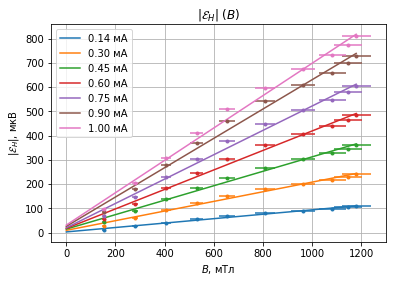

In [64]:
d = he_tbl_UB.get_data()
he_K = []
he_K_err = []
he_I = []
he_I_err = []

for num in cols:
    x_clean, y_clean, equ = plot(d[('I', num, 'B')], abs(d[('I', num, 'U')]), label = num + ' мА',
                                 xerr = setup.B_eps * d[('I', num, 'B')], yerr = setup.V1_err, x_min = 0)
    mnk_tbl = mnk(x_clean, y_clean)
    he_K.append(float(mnk_tbl.get_data()['a']))
    he_K_err.append(float(mnk_tbl.get_data()['da']))
    he_I.append(float(num))
    he_I_err.append(setup.A2_err)

plt.title("$|\mathcal{E}_H| \; (B)$")
plt.xlabel("$B$, мТл")
plt.ylabel("$|\mathcal{E}_H|$, мкВ")
plt.grid(True)
plt.legend()

plt.savefig("gen/hallEMF_UB.pdf")


,I,K,I_err,K_err
0,0.14,0.091033,0.005,0.003296
1,0.30,0.198624,0.005,0.007078
2,0.45,0.297640,0.005,0.010660
3,0.60,0.401524,0.005,0.014758
4,0.75,0.501821,0.005,0.018176
5,0.90,0.604210,0.005,0.023036
6,1.00,0.666886,0.005,0.024095


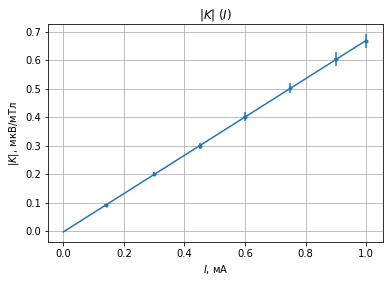

In [65]:
he_tbl_KI = table(pd.DataFrame())
he_tbl_KI.insert(loc = 0, column = 'I', value = he_I, fmt = [r'$I$, мА', '{:.3f}', 0])
he_tbl_KI.insert(loc = 1, column = 'K', value = he_K, fmt = [r'$|K|$, $\frac{\text{мкВ}}{\text{мТл}}$', '{:.3f}', 0])
he_tbl_KI.insert(loc = 2, column = 'I_err', value = he_I_err, fmt = [r'$\Delta I$, мА', '{:.3f}', 0])
he_tbl_KI.insert(loc = 3, column = 'K_err', value = he_K_err, fmt = [r'$\Delta |K|$, $\frac{\text{мкВ}}{\text{мТл}}$', '{:.3f}', 0])

he_tbl_KI.rename().to_latex('gen/hallEMF_KI.tex')

x_clean, y_clean, equ = plot(he_I, he_K, xerr = he_I_err, yerr = he_K_err, x_min = 0)
mnk_tbl = mnk(x_clean, y_clean, file = 'gen/hallEMF_KI_mnk.tex', precision = 3)

plt.title("$|K| \; (I)$")
plt.xlabel("$I$, мА")
plt.ylabel("$|K|$, мкВ/мТл")
plt.grid(True)

plt.savefig("gen/hallEMF_KI.pdf")

he_tbl_KI.get_data()

In [66]:
m = mnk_tbl.get_data()

R_H = setup.plate_h * float(m['a']) * 10 ** -3
R_H_err = R_H * np.sqrt( (float(m['da'])/float(m['a'])) ** 2 + (setup.plate_err / setup.plate_h) ** 2 )
print('R_H = ({:.2e} +- {:.2e})'.format(R_H, R_H_err))

n = 1 / (R_H * 1.6 * 10 ** -19)
n_err = n * R_H_err / R_H
print('n = ({:.2e} +- {:.2e})'.format(n, n_err))

R_H = (6.72e-04 +- 3.37e-05)
n = (9.29e+21 +- 4.66e+20)


R_H = (6.89e-04 +- 3.51e-05)
n = (9.07e+21 +- 4.63e+20)


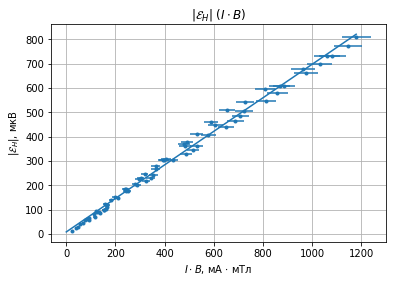

In [67]:
he_IB = []
he_U = []

for num in cols:
    for idx in range(0, len(d[('I', num, 'B')])):
        he_IB.append(float(num) * d[('I', num, 'B')][idx])
        he_U.append(abs(d[('I', num, 'U')][idx]))

x, y, equ = plot(he_IB, he_U, xerr = setup.B_eps * np.array(he_IB), yerr = setup.V1_err, x_min = 0)
mnk_tbl = mnk(x, y, file = 'gen/hallEMF_UIB_mnk.tex', precision = 3)

plt.title("$|\mathcal{E}_H| \; (I \cdot B)$")
plt.xlabel("$I \cdot B$, мА $\cdot$ мТл")
plt.ylabel("$|\mathcal{E}_H|$, мкВ")
plt.grid(True)

plt.savefig("gen/hallEMF_UIB.pdf")

m = mnk_tbl.get_data()

R_H = setup.plate_h * float(m['a']) * 10 ** -3
R_H_err = R_H * np.sqrt( (float(m['da'])/float(m['a'])) ** 2 + (setup.plate_err / setup.plate_h) ** 2 )
print('R_H = ({:.2e} +- {:.2e})'.format(R_H, R_H_err))

n = 1 / (R_H * 1.6 * 10 ** -19)
n_err = n * R_H_err / R_H
print('n = ({:.2e} +- {:.2e})'.format(n, n_err))

## Conductivity

In [68]:
xls = {
    'I, mA' : 'I',
    'U_35, mV' : 'U',
}

cond_data = read_excel("data/334.ods", usecols = range(6, 8), header = 0, nrows = 7)
cond_data = map_excel(cond_data, xls)
cond_data

,I,U
0,0.14,0.544
1,0.30,1.203
2,0.45,1.800
3,0.60,2.395
4,0.75,3.007
5,0.90,3.623
6,1.00,4.025


In [69]:
cond_fmt = {
    'I' : ['$I$, мА', '{:.2f}', 0],
    'U' : ['$U_{35}$, мВ', '{:.3f}', 0],
}

cond_tbl = table(cond_data, cond_fmt)
cond_tbl.rename().to_latex('gen/cond_UI.tex')

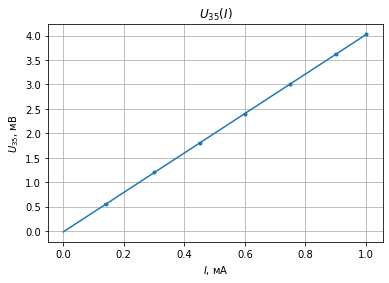

In [70]:
d = cond_tbl.get_data()
x_clean, y_clean, equ = plot(d['I'], d['U'], xerr = setup.A2_err, yerr = setup.V1_err / 10 ** 3, x_min = 0)
mnk_tbl = mnk(x_clean, y_clean, file = 'gen/cond_UI_mnk.tex')
cond_k = float(mnk_tbl.get_data()['a'])

plt.title("$U_{35} (I)$")
plt.xlabel("$I$, мА")
plt.ylabel("$U_{35}$, мВ")
plt.grid(True)

plt.savefig("gen/cond_UI.pdf")


In [71]:
m = mnk_tbl.get_data()

sigma_0 = setup.plate_l / (float(m['a']) * setup.plate_h * setup.plate_a) * 10**3
sigma_0_err = sigma_0 * np.sqrt( (float(m['da'])/float(m['a']))**2 + 3*(setup.plate_err / setup.plate_h)**2 )
print('sigma_0 = ({:.2e} +- {:.2e})'.format(sigma_0, sigma_0_err))

b = sigma_0 / (1.6 * 10**-19 * n) * 10**4
b_err = b * np.sqrt( (sigma_0_err / sigma_0)**2 + (n_err / n)**2 )
print('b = ({:.2e} +- {:.2e})'.format(b, b_err))

sigma_0 = (3.09e+02 +- 2.68e+01)
b = (2.13e+03 +- 2.14e+02)
